# **POD-NN**

POD-NN is a strategy that allows not to rely on affinity on the online stage: the projection stage is not performed and thus the speedup is guaranteed, yes having accurate solutions.
The POD-NN algorithm relies on two stages:
1. a POD,
2. a training of a Feed-forward Neural Network that predicts the entries of the reduced vector $u_{\mathsf{rb}}$.

As usual, we need **a lot of FOM simulations**. Let us import gedim!

In [1]:
import sys
sys.path.append('/content/CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

Solving the following equation on square $\bar{\Omega} = [-1, +1] \times [-1, +1]$

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) = 0 & \text{in } \Omega\\
k_{\mu} \nabla u \cdot n_1 = \mu_2 & \text{in } \Gamma_{down}\\
u = \sin(\mu_3\pi x) & \text{in } \Gamma_{up}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} 
\end{cases}
$$

where $k = \mu_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise. 
The parametric space is $\mathcal P = [0.1, 10] \times [0,1] \times [-1, 1]$.

The problem is _standard_. However, we note a nonlinear dependency of the Dirichlet boundary term over $\Gamma_{up}$.

In [4]:
def Heat_R():
	return 0.5

def Domain(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	return values.ctypes.data

############## DIRICHLET VARYING WRT mu_3 #####################
def Dirichlet_Term(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		values[p] = np.sin(mu_3*np.pi*matPoints[0,p])  ### mu_3 is not defined, but not a problem
	return values.ctypes.data
###################

def Circle(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) > (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def NotCircle(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def Heat_weakTerm_down(numPoints, points):
	values = np.ones(numPoints) 
	return values.ctypes.data

Let us define the High Fidelity Simulation Parameters and import the mesh.

In [5]:
order = 1

In [6]:
%%writefile ImportMesh.csv
InputFolderPath
/content/CppToPython/Meshes/Mesh3

Writing ImportMesh.csv


In [7]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

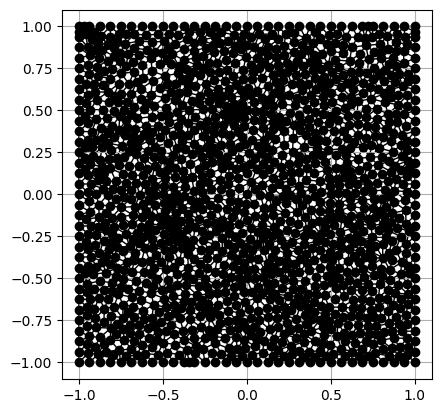

In [8]:
gedim.PlotMesh(mesh)

Let us create the space

In [9]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

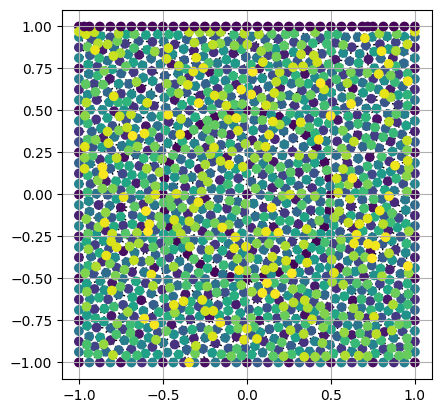

In [10]:
gedim.PlotDofs(mesh, dofs, strongs)

### **Assemble the system**
We can assemble only the parts that are $\mu-$independent (together with the inner product matrix!). Namely, the Dirichlet term needs to be assembled later on. It is non-affine and nonlinear w.r.t to the parameter $\boldsymbol\mu$!


In [11]:

[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(NotCircle, problemData, lib)
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Circle, problemData, lib)
	
weakTerm_down1 = gedim.AssembleWeakTerm(Heat_weakTerm_down, 1, problemData, lib)


#### inner product  
# ||grad(u)||^2 


inner_product = stiffness1 + stiffness2

######## DIRICHLET CANNOT BE ASSEMBLED NOW #########################



Let us define the training set for the POD

In [12]:
### define the training set

snapshot_num = 300
mu1_range = [0.1, 10.]
mu2_range = [-1., 1.]
mu3_range = [-1., 1.]
P = np.array([mu1_range, mu2_range, mu3_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))




We can now proceed with the snapshot matrix creation. However, we need to be careful: the problem is not affine in the parameters and we need to assemble the Dirichlet term for each parametric instance.

In [13]:
#### snapshot matrix creation
thetaA1 = 1
snapshot_matrix = []

tol = 1. - 1e-7
N_max = 10

for mu in training_set:
  thetaA2 = mu[0]
  thetaf1 = mu[1]
  mu_3 = mu[2]
  
  #### the problem is not affine: I have to assemble in this stage!! ###
  Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
  f1_D = stiffnessStrong1 @ Dirichlet_top
  f2_D = stiffnessStrong2 @ Dirichlet_top

  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1
  Dirichlet_contribution = thetaA1*f1_D + thetaA2*f2_D
  
  f = weakTerm_down - Dirichlet_contribution
  
  snapshot = gedim.LUSolver(stiffness, f, lib)
  
  # if you do not want to plot uncomment
  # gedim.PlotSolution(mesh, dofs, strongs, snapshot, Dirichlet_top)
  
  
  snapshot_matrix.append(np.copy(snapshot))

snapshot_matrix = np.array(snapshot_matrix) 

  

Let us build and analyze the covariance matrix.

In [14]:
### covariance matrix

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) ## metti inner product

# VM, L, VMt = np.linalg.svd((C))

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print(N)
print(relative_retained_energy)





9
[0.9043245  0.96427886 0.9960146  0.99881668 0.99996947 0.99999748
 0.99999949 0.99999983 0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1

And now let us build the basis functions and $\mathbb B$.

In [15]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  basis = np.transpose(snapshot_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) ## metti inner product
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))


If we want to perform standard ROMs we still need to assemble the system.

**Can we asseble it?**

In [16]:
########## ASSEMBLE WHAT I CAN ##### STILL OFFLINE
reduced_stiff1 = np.transpose(basis_functions) @ stiffness1 @ basis_functions
reduced_stiff2 = np.transpose(basis_functions) @ stiffness2 @ basis_functions
reduced_w =  np.transpose(basis_functions) @ weakTerm_down1


For each new parameter I have to assemble the Dirichlet term, once again.

In [17]:
########### I CANNOT DO THAT ################ STILL ONLINE??? WE NEED THE PARAMETER
thetaA2 = 2.
thetaf1 = 0.8
mu_3 = 1.
  

In [18]:
#### the problem is not affine: I have to assemble in this stage!! ###

Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
f1_D = stiffnessStrong1 @ Dirichlet_top
f2_D = stiffnessStrong2 @ Dirichlet_top
r_f1_D = np.transpose(basis_functions) @ (stiffnessStrong1 @ Dirichlet_top)
r_f2_D = np.transpose(basis_functions) @ (stiffnessStrong2 @ Dirichlet_top)


**Solve linear system for a new $\mu$**


In [19]:
reduced_rhs = thetaA1*reduced_stiff1 + thetaA2*reduced_stiff2
reduced_lhs = thetaf1*reduced_w - (thetaA1*r_f1_D + thetaA2*r_f2_D)

In [20]:
#####solve 

reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
print(reduced_solution)

[  0.03290216   5.79619361   4.91459343 -14.76570986  -1.390488
  -3.49997387  -0.323218    -7.36517397 -21.67476535]


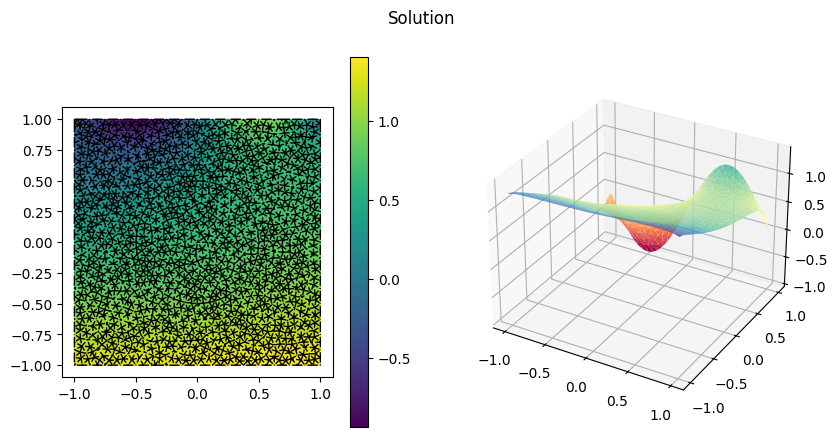

In [21]:
###### plot #######àà
proj_reduced_solution = basis_functions @ reduced_solution
gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)

stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
weakTerm_down = thetaf1*weakTerm_down1
f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
  
full_solution = gedim.LUSolver(stiffness, f, lib)



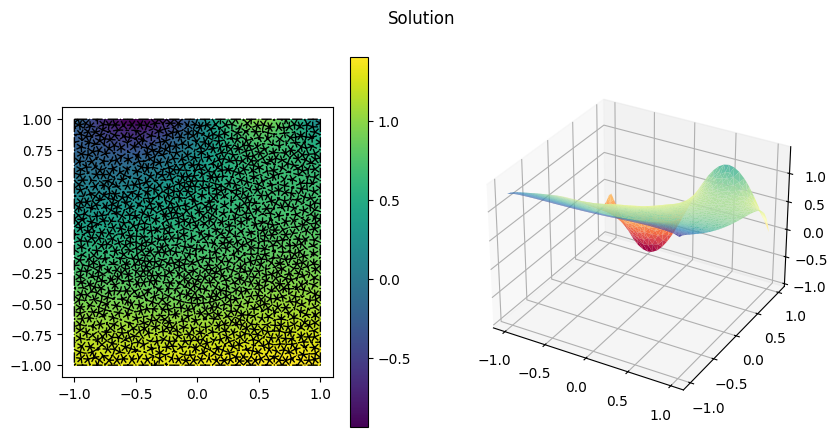

In [22]:
gedim.PlotSolution(mesh, dofs, strongs, full_solution, Dirichlet_top)

Let us comment a bit on the error analysis and the _speed up_.

In [23]:
### compute error
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
  
  thetaA2 = mu[0]
  thetaf1 = mu[1]
  mu_3 = mu[2]
  
  #### the problem is not affine: I have to assemble in this stage!! ###
  start_assembling = time.time()
  Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
  f1_D = stiffnessStrong1 @ Dirichlet_top
  f2_D = stiffnessStrong2 @ Dirichlet_top
  r_f1_D = np.transpose(basis_functions) @ (stiffnessStrong1 @ Dirichlet_top)
  r_f2_D = np.transpose(basis_functions) @ (stiffnessStrong2 @ Dirichlet_top)
  time_assembling =  time.time() - start_assembling

  ##### full #####
  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1
  f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
  
  
  start_fom = time.time()
  full_solution = gedim.LUSolver(stiffness, f, lib)
  time_fom = time.time() - start_fom

  #### reduced #####

  reduced_rhs = thetaA1*reduced_stiff1 + thetaA2*reduced_stiff2
  reduced_lhs = thetaf1*reduced_w - (thetaA1*r_f1_D + thetaA2*r_f2_D)
  
  start_rom = time.time()
  reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
  time_rom = time.time() - start_rom
  
  speed_up.append(time_fom/(time_rom + time_assembling))
  
  proj_reduced_solution = basis_functions@reduced_solution

  ### computing error

  error_function = full_solution - proj_reduced_solution
  error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
  absolute_error = np.sqrt(abs(error_norm_squared_component))
  abs_err.append(absolute_error)
  
  full_solution_norm_squared_component = np.transpose(full_solution) @  inner_product @ full_solution
  relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
  rel_err.append(relative_error)
  

Computing error and speedup analysis


In [24]:
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )
print("avarege speed_up = ", np.mean(speed_up) )

avarege relative error =  0.00013888979141686564
avarege absolute error =  0.00042728930413369546
avarege speed_up =  7.009801326786022


The speed up is quite small for a linear problem. Let understand the role of POD-NN in this setting. 

We want to use a feed-forward NN. Let us define the Class Net with pytorch.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

mu_dim = P.shape[0]
basis_dim = N 
input_dim = mu_dim
output_dim = basis_dim
nodes = 30

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, output_dim)
        self.tanh = nn.Tanh()
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

In [26]:
seed_num = 31
torch.manual_seed(seed_num)
net = Net()
torch.set_default_dtype(torch.float32)

my_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epoch_max = 500000
epoch = 0
tol = 1e-5
loss = 1.

We need to prepare the outputs to train the NN. Indeed, our goal is to define 
$$
\boldsymbol \pi(\boldsymbol \mu) = \underline{u}_{\mathsf{rb}}^{NN}(\boldsymbol \mu).
$$
 Namely, our inputs are the parameters of the training set and the output is the Galerkin projection of the snapshots of the training set.
 The output is of the form $\underline{u}_{\mathsf{rb}}$ where:
 $$
 \mathbb B \underline{u}_{\mathsf{rb}}(\boldsymbol \mu) = \mathbb P^{\boldsymbol \mu}u_{{\delta}}(\boldsymbol \mu), \quad \quad (1)
 $$
 where $\mathbb P^{\boldsymbol \mu} = \mathbb B \mathbb X_{N}^{-1} \mathbb B^T\mathbb X_{N_{\delta}}$ is the reduced vector related to the Galrkin projector, i.e. the best approximation of $u_\delta$ in $V_N$ w.r.t. the inner-product defined by the matrix $X_\delta$.

 Instead of computing the inverse of $\mathbb X_{N} = \mathbb B^T \mathbb X_{{\delta}} \mathbb B$ we solve the following system:
 $$
 \mathbb B^T \mathbb X_{{\delta}} \mathbb B \underline{u}_{\mathsf {rb}}(\boldsymbol \mu) =
 \mathbb X_{N} \mathbb B \underline{u}_{\mathsf {rb}}(\boldsymbol \mu)
  \mathbb B^T \mathbb X_{{\delta}} u_{{\delta}}(\boldsymbol \mu)
 $$
 to find $u_{\mathsf{rb}}(\boldsymbol \mu)$ for each snapshot.

In this way we are taking the vector of the reduced solution related to the parameter $\boldsymbol \mu$ **without solving the reduced system**, thanks to the relation (1). This element is the closest element (the best choice) to $u_{\delta}$ in the norm of the problem.

In [27]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set))
y_train = []


for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot)

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)


Let us train our neural network!

In [ ]:
while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  if epoch >= 20000:
    optimizer.param_groups[0]['lr'] = 0.0001  
  #compute the gradients
  loss.backward()
  # optimizer update
  optimizer.step()
  if epoch % 200 == 199:
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )
              

epoch 199 loss 7.6057820320129395 lr 0.001
epoch 399 loss 4.839061260223389 lr 0.001
epoch 599 loss 2.6849403381347656 lr 0.001
epoch 799 loss 1.5106875896453857 lr 0.001
epoch 999 loss 0.9186849594116211 lr 0.001
epoch 1199 loss 0.6604220271110535 lr 0.001
epoch 1399 loss 0.4860302805900574 lr 0.001
epoch 1599 loss 0.3624696731567383 lr 0.001
epoch 1799 loss 0.28086426854133606 lr 0.001
epoch 1999 loss 0.21408523619174957 lr 0.001
epoch 2199 loss 0.1643746793270111 lr 0.001
epoch 2399 loss 0.1288723349571228 lr 0.001
epoch 2599 loss 0.10112825781106949 lr 0.001
epoch 2799 loss 0.0800192579627037 lr 0.001
epoch 2999 loss 0.06410424411296844 lr 0.001
epoch 3199 loss 0.05343788489699364 lr 0.001
epoch 3399 loss 0.040938764810562134 lr 0.001
epoch 3599 loss 0.03311026096343994 lr 0.001
epoch 3799 loss 0.02708626165986061 lr 0.001
epoch 3999 loss 0.02394300140440464 lr 0.001
epoch 4199 loss 0.01906908117234707 lr 0.001
epoch 4399 loss 0.016572022810578346 lr 0.001
epoch 4599 loss 0.0146280

Let us compute a specific instance of the problem! Namely we compute $\boldsymbol \pi (\boldsymbol \mu_{test})$.

**What is the output?**

Let us compare it with the full solution.

**What do I have to do?**

In [ ]:
x_test = [[6., .1, 1.]]
x_test = np.float32(x_test)
x_test = torch.tensor(x_test)

reduced_solution = np.asarray(net(x_test).detach().numpy())[0]

print(reduced_solution)



In [ ]:
nn_proj_reduced_solution = basis_functions @ reduced_solution
mu = x_test[0]
thetaA2 = mu[0].item()
thetaf1 = mu[1].item()
mu_3 = mu[2].item()
thetaA1 = 1
Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib)
 

gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, Dirichlet_top)

In [ ]:
##### full #####

stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
weakTerm_down = thetaf1*weakTerm_down1
f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
full_solution = gedim.LUSolver(stiffness, f, lib)
  

full_solution = gedim.LUSolver(stiffness, f, lib)
gedim.PlotSolution(mesh, dofs, strongs, full_solution, Dirichlet_top)

Let us perform an error analysis and comment on the speed up!

In [ ]:
### compute error
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
  
  thetaA2 = mu[0]
  thetaf1 = mu[1]
  mu_3 = mu[2]
  
  #### I DO NOT NEED THE SOLVE #####
  Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
  
  ##### full #####
  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1
  f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
  
  
  start_fom = time.time()
  full_solution = gedim.LUSolver(stiffness, f, lib)
  time_fom = time.time() - start_fom
  # gedim.PlotSolution(mesh, dofs, strongs, full_solution, Dirichlet_top)
  #### reduced #####

  x_test = [[mu[0], mu[1], mu[2]]]
  x_test = np.float32(x_test)
  x_test = torch.tensor(x_test)

  start_rom = time.time()
  reduced_solution = np.asarray(net(x_test).detach().numpy())[0]
  time_rom = time.time() - start_rom
  
  speed_up.append(time_fom/(time_rom))
  
  proj_reduced_solution = basis_functions@reduced_solution
  # gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)

  
  ### computing error

  error_function = full_solution - proj_reduced_solution
  error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
  absolute_error = np.sqrt(abs(error_norm_squared_component))
  print(absolute_error)
  abs_err.append(absolute_error)
  
  full_solution_norm_squared_component = np.transpose(full_solution) @  inner_product @ full_solution
  relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
  rel_err.append(relative_error)
  print(relative_error)
  


In [ ]:
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )
print("avarege speed_up = ", np.mean(speed_up) )